**CAR PRICE PREDICTION**


**Objective**
- build the models to determine the value. 
- choose the best by the quality of the prediction, the speed of the prediction and the time required for training

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from catboost import CatBoostRegressor, Pool
import lightgbm as lgb

**DATA PREPROCESSING**

In [2]:
df = pd.read_csv('car_data.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [4]:
df = df.drop_duplicates()

In [5]:
df = df.drop(['DateCrawled', 'LastSeen', 'PostalCode', 'RegistrationMonth', 'NumberOfPictures'], axis = 1)

In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.isna().mean()

price               0.000000
vehicletype         0.105855
registrationyear    0.000000
gearbox             0.056000
power               0.000000
model               0.055636
mileage             0.000000
fueltype            0.092879
brand               0.000000
notrepaired         0.200914
datecreated         0.000000
dtype: float64

In [8]:
df['age'] = (pd.to_datetime(df['datecreated']).dt.year.astype('Int64') - df['registrationyear']).astype('Int64') + 1
df = df.drop(['registrationyear', 'datecreated'], axis = 1)

In [9]:
df['mileage_per_year'] = df['mileage']/df['age'].astype('Int64')

In [10]:
df['notrepaired'] = df['notrepaired'].fillna('unknown')
df['vehicletype'] = df['vehicletype'].fillna('unknown')
df['model'] = df['model'].fillna('unknown')
df['gearbox'] = df['gearbox'].fillna(df.groupby('model')['gearbox'].transform('first'))

In [11]:
len(df.dropna())/len(df)

0.9071212938462103

In [12]:
df = df.dropna()

In [13]:
df = df.query('age >0')

In [14]:
list_borders = []
for col in ['price', 'age', 'power', 'mileage_per_year', 'mileage']:
    upper_bound_boxplot_extreme = 4*df[col].quantile(0.75)-3*df[col].quantile(0.25)
    print('Outliers for', col, upper_bound_boxplot_extreme)
    list_borders.append(upper_bound_boxplot_extreme)


Outliers for price 23600.0
Outliers for age 42.0
Outliers for power 347.0
Outliers for mileage_per_year 27500.0
Outliers for mileage 225000.0


In [15]:
df = df.query('price < @list_borders[0] and price > 100 and age < @list_borders[1] and power < @list_borders[2] and power > 0 and mileage_per_year < @list_borders[3] and mileage < @list_borders[4]')

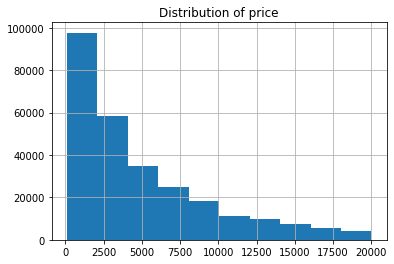

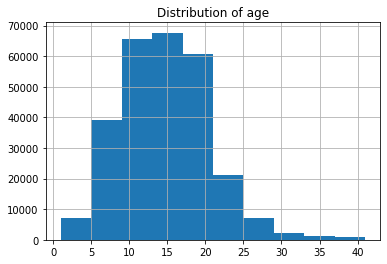

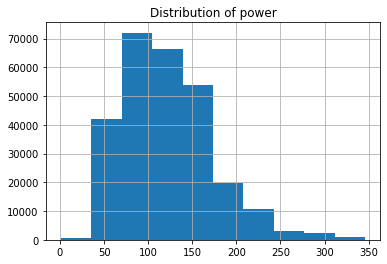

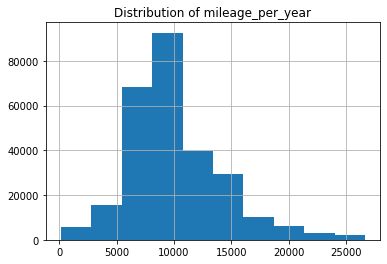

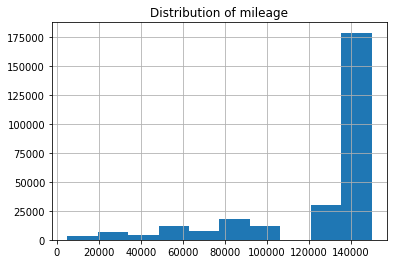

In [16]:
for col in ['price', 'age', 'power', 'mileage_per_year', 'mileage']:
    df[col].hist()
    plt.title(f'Distribution of {col}')
    plt.show()

**Conclusion**
- duplicates removed
- outliers removed
- removed non-informative columns
- rows with missing values removed

**DATA PREPARATION FOR ML**

In [17]:
numeric_columns = ['power', 'age', 'mileage_per_year', 'mileage']

In [18]:
categorical_columns = ['vehicletype', 'gearbox', 'model', 'fueltype', 'brand', 'notrepaired']

In [19]:
target = df['price']
features = df.drop('price', axis = 1)

In [20]:
target_train, target_valid, features_train, features_valid = train_test_split(target, features, test_size = 0.25, random_state = 13)

In [21]:
features_train = features_train.reset_index(drop = True)
features_valid = features_valid.reset_index(drop = True)
target_train = target_train.reset_index(drop = True)
target_valid = target_valid.reset_index(drop = True)

In [22]:
scaler = StandardScaler()
features_train[numeric_columns] = scaler.fit_transform(features_train[numeric_columns])
features_valid[numeric_columns] = scaler.transform(features_valid[numeric_columns])

In [23]:
encoder = OrdinalEncoder()
features_train[categorical_columns] = encoder.fit_transform(features_train[categorical_columns])
features_valid[categorical_columns] = encoder.transform(features_valid[categorical_columns])

**Conclusion**
- data splited on test and validate samples
- categorical values transformed in numerical with OrdinalEncoder
- numerical values standartized

**LINEAR REGRESSION**

In [24]:
%%time
model = LinearRegression()
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
print('RMSE for linear regression:', round(mean_squared_error(predicted_valid, target_valid)**0.5, 0))

RMSE for linear regression: 2488.0
CPU times: total: 141 ms
Wall time: 604 ms


**RANDOM FOREST REGRESSOR**

In [ ]:
%%time
param_grid = {
    'n_estimators': [50, 150, 200],
    'max_depth': [8, 12, 16, 20],
    'min_samples_split': [2, 5, 7]
}

model = RandomForestRegressor(random_state = 123)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(features_train, target_train)
grid_search.best_params_

In [25]:
%%time
model = RandomForestRegressor(max_depth = 20, min_samples_split = 7, n_estimators = 200, random_state = 123)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
predicted_train = model.predict(features_train)
print('RMSE random forest for validation:', round(mean_squared_error(predicted_valid, target_valid)**0.5, 0))
print('RMSE random forest for train:', round(mean_squared_error(predicted_train, target_train)**0.5, 0))

RMSE random forest for validation: 1504.0
RMSE random forest for train: 1095.0
CPU times: total: 2min 51s
Wall time: 2min 53s


**CATBOOST**

In [40]:
%%time
model = CatBoostRegressor(loss_function='RMSE', random_state = 456)
parameters = {'iterations': [400, 800],
        'learning_rate': [0.03, 0.1, 0.2],
        'depth': [4, 8, 12],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}
grid = GridSearchCV(estimator = model, param_grid = parameters, cv = 4, n_jobs=-1, verbose=0)
grid.fit(features_train, target_train) 
grid.best_params_

0:	learn: 4240.6978510	total: 175ms	remaining: 2m 20s
1:	learn: 3927.6168232	total: 388ms	remaining: 2m 34s
2:	learn: 3654.6558154	total: 563ms	remaining: 2m 29s
3:	learn: 3412.7755784	total: 742ms	remaining: 2m 27s
4:	learn: 3202.7343170	total: 931ms	remaining: 2m 27s
5:	learn: 3016.8781984	total: 1.11s	remaining: 2m 27s
6:	learn: 2852.2748371	total: 1.28s	remaining: 2m 25s
7:	learn: 2706.2181555	total: 1.46s	remaining: 2m 24s
8:	learn: 2578.8015516	total: 1.64s	remaining: 2m 23s
9:	learn: 2469.8468905	total: 1.81s	remaining: 2m 23s
10:	learn: 2370.7273858	total: 2.04s	remaining: 2m 26s
11:	learn: 2285.9988541	total: 2.21s	remaining: 2m 25s
12:	learn: 2215.0980111	total: 2.38s	remaining: 2m 24s
13:	learn: 2154.2649734	total: 2.57s	remaining: 2m 24s
14:	learn: 2098.4322782	total: 2.78s	remaining: 2m 25s
15:	learn: 2047.6148713	total: 2.97s	remaining: 2m 25s
16:	learn: 2003.5793050	total: 3.17s	remaining: 2m 26s
17:	learn: 1963.3128320	total: 3.46s	remaining: 2m 30s
18:	learn: 1926.7085

{'depth': 12, 'iterations': 800, 'l2_leaf_reg': 0.2, 'learning_rate': 0.1}

In [41]:
%%time
model = CatBoostRegressor(depth = 12, iterations = 800, l2_leaf_reg = 0.2, learning_rate= 0.1, loss_function='RMSE')
model.fit(features_train, target_train) 
predicted_valid = model.predict(features_valid)
predicted_train = model.predict(features_train)
print('RMSE CATBOOST for validation:', round(mean_squared_error(predicted_valid, target_valid)**0.5, 0))
print('RMSE CATBOOST for train :', round(mean_squared_error(predicted_train, target_train)**0.5, 0))

0:	learn: 4239.3240937	total: 132ms	remaining: 1m 45s
1:	learn: 3929.4423292	total: 260ms	remaining: 1m 43s
2:	learn: 3653.0012244	total: 399ms	remaining: 1m 45s
3:	learn: 3411.1029129	total: 529ms	remaining: 1m 45s
4:	learn: 3199.3732473	total: 666ms	remaining: 1m 45s
5:	learn: 3015.6783963	total: 798ms	remaining: 1m 45s
6:	learn: 2855.3208815	total: 967ms	remaining: 1m 49s
7:	learn: 2715.8772959	total: 1.13s	remaining: 1m 51s
8:	learn: 2587.0565171	total: 1.31s	remaining: 1m 55s
9:	learn: 2474.2250819	total: 1.49s	remaining: 1m 57s
10:	learn: 2376.9926515	total: 1.66s	remaining: 1m 58s
11:	learn: 2290.8034986	total: 1.8s	remaining: 1m 58s
12:	learn: 2216.4147265	total: 1.95s	remaining: 1m 58s
13:	learn: 2150.8471073	total: 2.11s	remaining: 1m 58s
14:	learn: 2097.3651663	total: 2.26s	remaining: 1m 58s
15:	learn: 2044.3037649	total: 2.39s	remaining: 1m 57s
16:	learn: 2001.6769906	total: 2.53s	remaining: 1m 56s
17:	learn: 1959.5280924	total: 2.67s	remaining: 1m 56s
18:	learn: 1921.72317

**LGBM**

In [42]:
%%time
train_data = lgb.Dataset(features_train, label=target_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.5,
    'max_depth': 6, 
    'num_leaves': 10,
    'verbose': 0
}


model = lgb.train(params, train_data, num_boost_round=800)
predicted_valid = model.predict(features_valid)
predicted_train = model.predict(features_train)
print('RMSE LGBM for validation:', round(mean_squared_error(predicted_valid, target_valid)**0.5, 0))
print('RMSE LGBM for train:', round(mean_squared_error(predicted_train, target_train)**0.5, 0))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
RMSE LGBM for validation: 1510.0
RMSE LGBM for train: 1357.0
CPU times: total: 30.5 s
Wall time: 8.31 s


**Conclusion**

The fastest model is LinearRegression, but it has the highest RMSE.

Thus, for the best combination of speed / quality, we can choose CatBoost